In [1]:
from transformer import Transformer
import pandas as pd
import numpy as np
import tqdm
import re
import torch 
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
import matplotlib.pyplot as plt

<h2>Loading Split Data</h2>

In [2]:
####Training Set #####
# Load the CSV file
training_set_df = pd.read_csv('training_set_1.csv')
test_set_df = pd.read_csv('test_set_1.csv')

# Access the arrays
z_training_set = training_set_df['z_target (m)'].values
TOD_training_set = training_set_df['TOD (s^3)'].values
n_protons_training_set = training_set_df['n_protons (1/sr)'].values

z_test_set = test_set_df['z_target (m)'].values
TOD_test_set = test_set_df['TOD (s^3)'].values
n_protons_test_set = test_set_df['n_protons (1/sr)'].values

<h2>Normalizing Data</h2>

In [3]:
#Setting Bounds
z_bounds = torch.tensor([-150, 150])
TOD_bounds = torch.tensor([-80e3, 80e3])
protons_bounds = torch.tensor([min(n_protons_training_set), max(n_protons_training_set)])

#define transformers
transformer_z = Transformer(z_bounds.reshape(2,1), transform_type = 'normalize')
transformer_TOD = Transformer(TOD_bounds.reshape(2,1), transform_type = 'normalize')
transformer_n_protons = Transformer(protons_bounds.reshape(2,1), transform_type = 'normalize')

In [4]:
# Normalize datases
normed_z_train_set = transformer_z.forward(torch.tensor(z_training_set).reshape(-1,1))
normed_z_test_set = transformer_z.forward(torch.tensor(z_test_set).reshape(-1,1))

normed_TOD_train_set = transformer_TOD.forward(torch.tensor(TOD_training_set).reshape(-1,1))
normed_TOD_test_set = transformer_TOD.forward(torch.tensor(TOD_test_set).reshape(-1,1))

normed_np_train_set = transformer_n_protons.forward(torch.tensor(n_protons_training_set).reshape(-1,1))
normed_np_test_set = transformer_n_protons.forward(torch.tensor(n_protons_test_set).reshape(-1,1))

<Figure size 640x480 with 0 Axes>

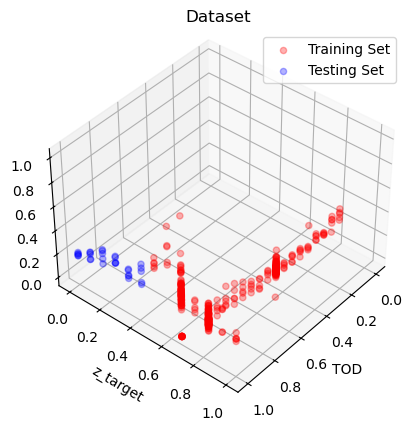

In [5]:
plt.clf()
ax = plt.figure().add_subplot(projection='3d')

ax.scatter( normed_TOD_train_set, normed_z_train_set,normed_np_train_set, c='r',alpha=0.3, label='Training Set')
ax.scatter( normed_TOD_test_set, normed_z_test_set,normed_np_test_set, c='b', alpha=0.3, label='Testing Set')
ax.view_init(elev=40., azim=40, roll=0)
plt.title('Dataset')
plt.xlabel('TOD')
plt.ylabel('z_target')
plt.legend()

In [6]:
train_x = torch.cat([normed_z_train_set, normed_TOD_train_set], dim=1).detach()
train_y = normed_np_train_set

test_x = torch.cat([normed_z_test_set, normed_TOD_test_set], dim=1).detach()
test_y = normed_np_test_set

<h1> Defining the Guassain Process & Training </h1>

In [8]:
gp_model = SingleTaskGP(train_x, train_y)
# train model hyperparameters minimizing negative-Log-Marginal-Likelihood
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_mll(mll)

/global/homes/o/oshapova/.local/perlmutter/pytorch2.3.1/lib/python3.11/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1134], dtype=torch.float64), mean = tensor([0.2925], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

<h1> Evaluating The Model </h1>

In [10]:
def eval_mode(model, x_data, y_data):
    """
    Perform predictions using the provided model and likelihood on the given input data.

    Parameters:
    - model: The trained model.
    - likelihood: The likelihood function associated with the model.
    - x_data: The input data for which predictions are to be made.

    Returns:
    - mean_prediction: The mean predictions from the model.
    - lower_bound: The lower bound of the confidence interval.
    - upper_bound: The upper bound of the confidence interval.
    """
    inputs = torch.cat([x_data, y_data], dim=1)
    model.eval()
    model.likelihood.eval()

    with torch.no_grad():
        predictions = model.likelihood(model(inputs))
        mean_prediction = predictions.mean  # Mean prediction
        lower_bound, upper_bound = predictions.confidence_region()  # Confidence interval

    return mean_prediction, lower_bound, upper_bound

In [11]:
test_mean_prediction, test_lower_set, test_upper_set = eval_mode(gp_model, normed_z_test_set, normed_TOD_test_set)

In [12]:
train_mean_prediction, train_lower_set, train_upper_set = eval_mode(gp_model, normed_z_train_set, normed_TOD_train_set)

/global/homes/o/oshapova/.local/perlmutter/pytorch2.3.1/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


<h1> Visualization </h1>

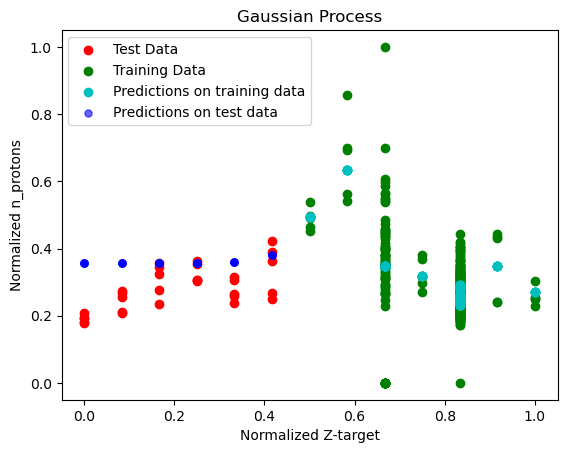

In [14]:
plt.figure()

show_confidence_interval = 'False'

# Scatter plot of the actual test data
plt.scatter(normed_z_test_set.numpy(), normed_np_test_set.numpy(), c='r', label='Test Data')
plt.scatter(normed_z_train_set.numpy(), normed_np_train_set.numpy(), c='g', label='Training Data')

plt.scatter(normed_z_train_set.numpy(), train_mean_prediction.numpy(), c='c', label='Predictions on training data')
plt.scatter(normed_z_test_set.numpy(), test_mean_prediction.numpy(), c='b', label='Predictions on test data', alpha=0.6, s=25.89)

plt.xlabel('Normalized Z-target')
plt.ylabel('Normalized n_protons')
plt.title('Gaussian Process')
plt.legend()

if show_confidence_interval == 'True':
    # Fill between the prediction intervals
    plt.fill_between(normed_z_test_set.squeeze().numpy(), test_lower_set.numpy(), test_upper_set.numpy(), alpha=0.1, color='red', label='Confidence Interval')
    plt.fill_between(normed_z_train_set.squeeze().numpy(), train_lower_set.numpy(), train_upper_set.numpy(), alpha=0.1, color='blue', label='Confidence Interval')

# Save the plot
# plt.savefig("./GP_A.png")
plt.show()

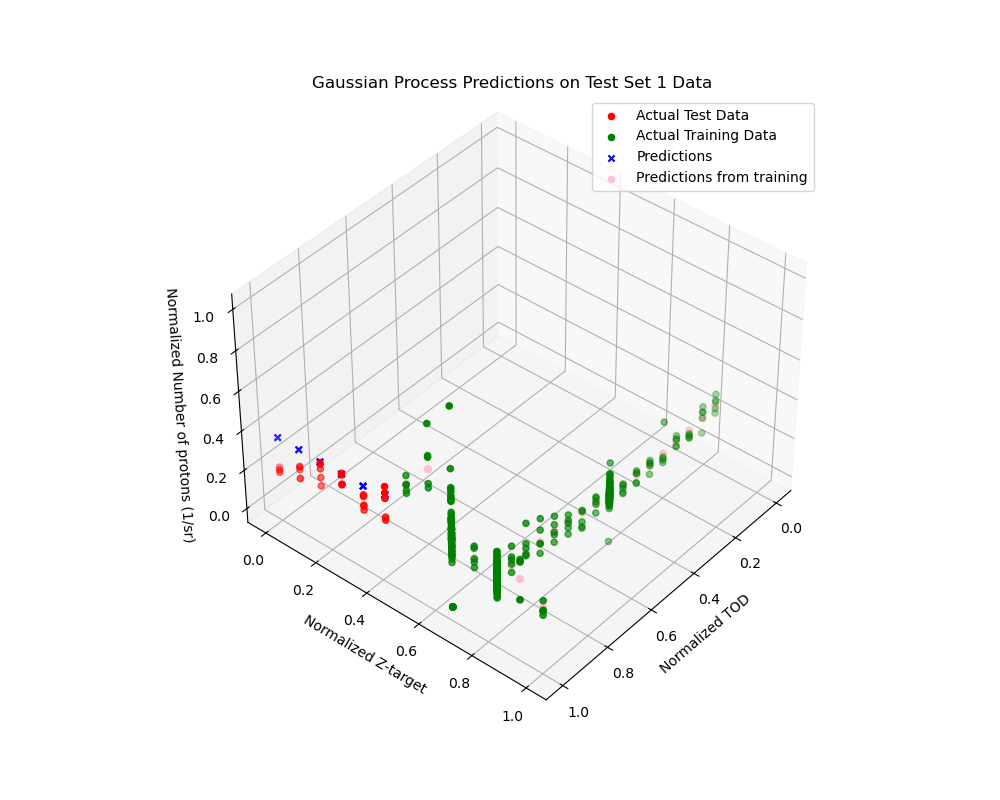

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the actual test data
ax.scatter(normed_TOD_test_set.numpy(), normed_z_test_set.numpy(), normed_np_test_set.numpy(), c='r', label='Actual Test Data')

# Scatter plot of the training data
ax.scatter(normed_TOD_train_set.numpy(), normed_z_train_set.numpy(), normed_np_train_set.numpy(), c='g', label='Actual Training Data')

# Scatter plot of the predictions
ax.scatter(normed_TOD_test_set.numpy(), normed_z_test_set.numpy(), test_mean_prediction.numpy(), c='b', marker='x', label='Predictions')

# Scatter plot of the predictions
ax.scatter(normed_TOD_train_set.numpy(), normed_z_train_set.numpy(), train_mean_prediction.numpy(), c='pink', label='Predictions from training')


ax.view_init(elev=40, azim=40, roll=0)
# Labels and legend
ax.set_xlabel('Normalized TOD')
ax.set_ylabel('Normalized Z-target')
ax.set_zlabel('Normalized Number of protons (1/sr)')
ax.set_title('Gaussian Process Predictions on Test Set 1 Data')
ax.legend()

#plt.savefig("GP.png")
plt.show()